<a href="https://colab.research.google.com/github/jvo024/spotify_songs_ads504/blob/jvo-eda/spotify_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.linear_model import Perceptron
import warnings

warnings.filterwarnings("ignore")

## 1. Import Dataset

In [ ]:
base_df = pd.read_csv('https://raw.githubusercontent.com/orzanai/Moodify/main/Datasets/278k_song_labelled.csv')
base_df.head()

Unnamed: 0  duration (ms)  danceability  energy  loudness  speechiness  \
0           0       195000.0         0.611   0.614    -8.815       0.0672   
1           1       194641.0         0.638   0.781    -6.848       0.0285   
2           2       217573.0         0.560   0.810    -8.029       0.0872   
3           3       443478.0         0.525   0.699    -4.571       0.0353   
4           4       225862.0         0.367   0.771    -5.863       0.1060   

   acousticness  instrumentalness  liveness  valence    tempo     spec_rate  \
0        0.0169          0.000794    0.7530    0.520  128.050  3.446154e-07   
1        0.0118          0.009530    0.3490    0.250  122.985  1.464234e-07   
2        0.0071          0.000008    0.2410    0.247  170.044  4.007850e-07   
3        0.0178          0.000088    0.0888    0.199   92.011  7.959809e-08   
4        0.3650          0.000001    0.0965    0.163  115.917  4.693131e-07   

   labels  
0       2  
1       1  
2       1  
3       0  
4       1

In [ ]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277938 entries, 0 to 277937
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        277938 non-null  int64  
 1   duration (ms)     277938 non-null  float64
 2   danceability      277938 non-null  float64
 3   energy            277938 non-null  float64
 4   loudness          277938 non-null  float64
 5   speechiness       277938 non-null  float64
 6   acousticness      277938 non-null  float64
 7   instrumentalness  277938 non-null  float64
 8   liveness          277938 non-null  float64
 9   valence           277938 non-null  float64
 10  tempo             277938 non-null  float64
 11  spec_rate         277938 non-null  float64
 12  labels            277938 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 27.6 MB


In [ ]:
base_df.describe().T

count          mean           std     min           25%  \
Unnamed: 0        277938.0  1.389685e+05  8.023393e+04     0.0  6.948425e+04   
duration (ms)     277938.0  2.324961e+05  1.171830e+05  6706.0  1.720130e+05   
danceability      277938.0  5.525834e-01  1.889048e-01     0.0  4.310000e-01   
energy            277938.0  5.568658e-01  2.796813e-01     0.0  3.420000e-01   
loudness          277938.0 -1.036365e+01  6.672049e+00   -60.0 -1.274700e+01   
speechiness       277938.0  8.791327e-02  1.125001e-01     0.0  3.590000e-02   
acousticness      277938.0  3.865827e-01  3.645043e-01     0.0  3.380000e-02   
instrumentalness  277938.0  2.550443e-01  3.737446e-01     0.0  0.000000e+00   
liveness          277938.0  1.892167e-01  1.635964e-01     0.0  9.620000e-02   
valence           277938.0  4.496018e-01  2.674714e-01     0.0  2.200000e-01   
tempo             277938.0  1.191960e+02  3.046226e+01     0.0  9.507225e+01   
spec_rate         277938.0  4.754654e-07  9.190229e-07     0.0  1.531461e-07   
labels            277938.0  1.179101e+00  1.021033e+00     0.0  0.000000e+00   

                           50%           75%           max  
Unnamed: 0        1.389685e+05  2.084528e+05  2.779370e+05  
duration (ms)     2.131055e+05  2.648660e+05  3.919895e+06  
danceability      5.710000e-01  6.930000e-01  9.890000e-01  
energy            5.910000e-01  7.920000e-01  1.000000e+00  
loudness         -8.397000e+00 -5.842000e+00  4.882000e+00  
speechiness       4.710000e-02  8.220000e-02  9.650000e-01  
acousticness      2.620000e-01  7.540000e-01  9.960000e-01  
instrumentalness  1.090000e-03  6.450000e-01  1.000000e+00  
liveness          1.210000e-01  2.270000e-01  1.000000e+00  
valence           4.340000e-01  6.650000e-01  1.000000e+00  
tempo             1.199400e+02  1.388698e+02  2.449470e+02  
spec_rate         2.345459e-07  4.449937e-07  5.971860e-05  
labels            1.000000e+00  2.000000e+00  3.000000e+00

In [ ]:
# convert lables column from 0,1,2,3 to actual labels for classification model
#new_labels = {0 : 'sad',
 #             1 : "happy",
  #            2 : 'energetic',
   #           3 : "calm"
      #        }
#base_df['labels'] = base_df['labels'].map(new_labels)
#base_df.head()

## 2. EDA & Pre-Processing

In [ ]:
# Remove iirevelevant columns
drop = ['Unnamed: 0']
base_df.drop(drop, axis = 1, inplace = True)

# Identify null values
base_df.isna().sum()

duration (ms)       0
danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
spec_rate           0
labels              0
dtype: int64

In [ ]:
base_df.shape

(277938, 12)

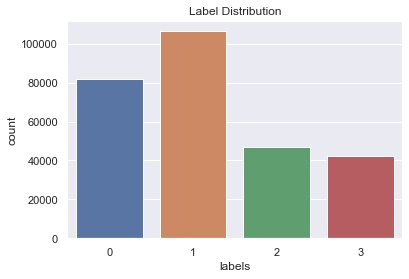

In [ ]:
sns.set(style="darkgrid")
sns.countplot(x = base_df['labels'])
plt.title('Label Distribution')
plt.show()

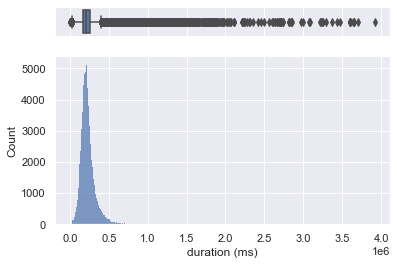

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(base_df["duration (ms)"], orient ="h", ax=ax_box)
sns.histplot(data=base_df, x="duration (ms)", ax=ax_hist)

ax_box.set(xlabel='')
plt.show()

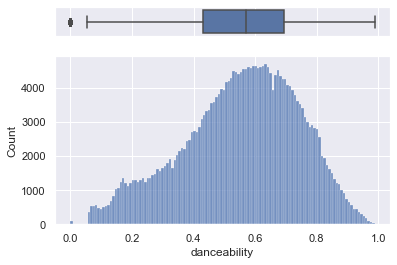

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(base_df["danceability"], orient ="h", ax=ax_box)
sns.histplot(data=base_df, x="danceability", ax=ax_hist)

ax_box.set(xlabel='')
plt.show()

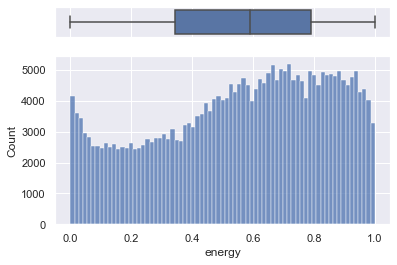

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(base_df["energy"], orient ="h", ax=ax_box)
sns.histplot(data=base_df, x="energy", ax=ax_hist)

ax_box.set(xlabel='')
plt.show()

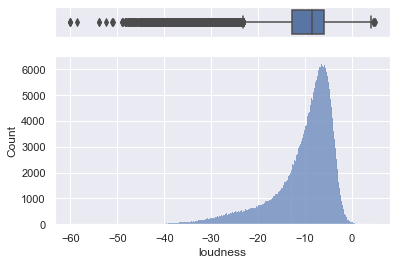

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(base_df["loudness"], orient ="h", ax=ax_box)
sns.histplot(data=base_df, x="loudness", ax=ax_hist)

ax_box.set(xlabel='')
plt.show()

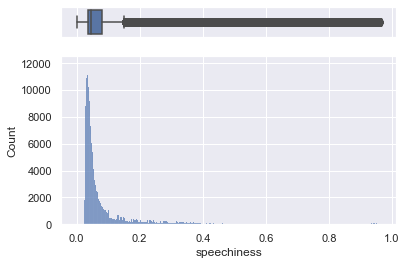

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(base_df["speechiness"], orient ="h", ax=ax_box)
sns.histplot(data=base_df, x="speechiness", ax=ax_hist)

ax_box.set(xlabel='')
plt.show()

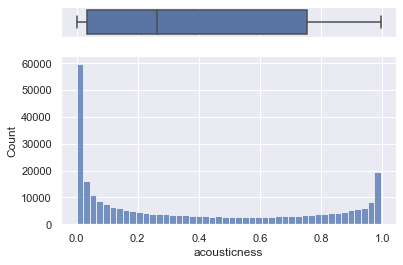

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(base_df["acousticness"], orient ="h", ax=ax_box)
sns.histplot(data=base_df, x="acousticness", ax=ax_hist)

ax_box.set(xlabel='')
plt.show()

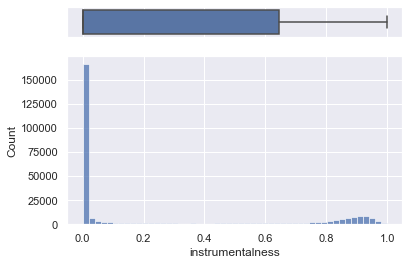

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(base_df["instrumentalness"], orient ="h", ax=ax_box)
sns.histplot(data=base_df, x="instrumentalness", ax=ax_hist)

ax_box.set(xlabel='')
plt.show()

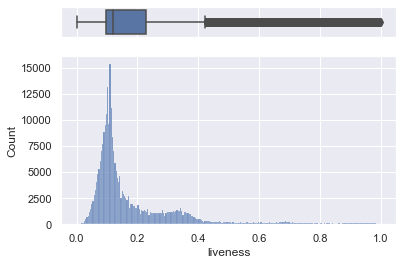

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(base_df["liveness"], orient ="h", ax=ax_box)
sns.histplot(data=base_df, x="liveness", ax=ax_hist)

ax_box.set(xlabel='')
plt.show()

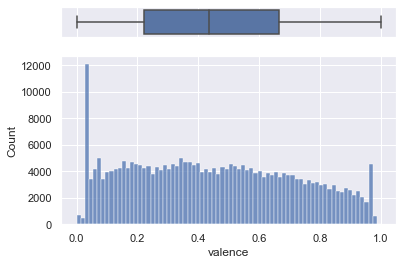

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(base_df["valence"], orient ="h", ax=ax_box)
sns.histplot(data=base_df, x="valence", ax=ax_hist)

ax_box.set(xlabel='')
plt.show()

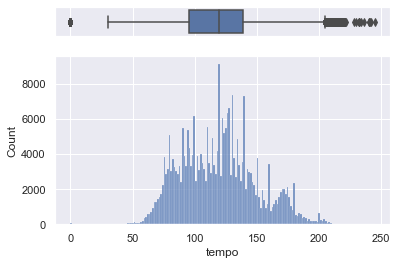

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(base_df["tempo"], orient ="h", ax=ax_box)
sns.histplot(data=base_df, x="tempo", ax=ax_hist)

ax_box.set(xlabel='')
plt.show()

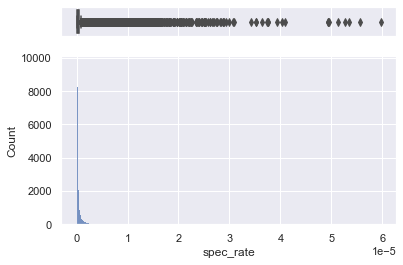

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(base_df["spec_rate"], orient ="h", ax=ax_box)
sns.histplot(data=base_df, x="spec_rate", ax=ax_hist)

ax_box.set(xlabel='')
plt.show()

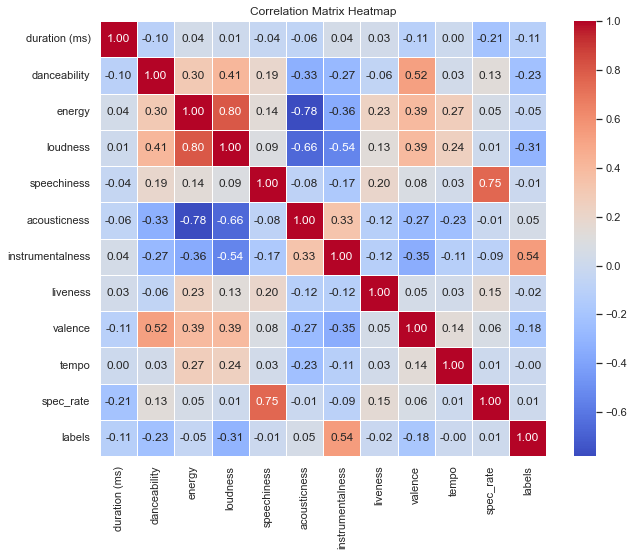

In [ ]:
# Numerical columns for the correlation matrix
numerical_columns = base_df.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numerical_columns.corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

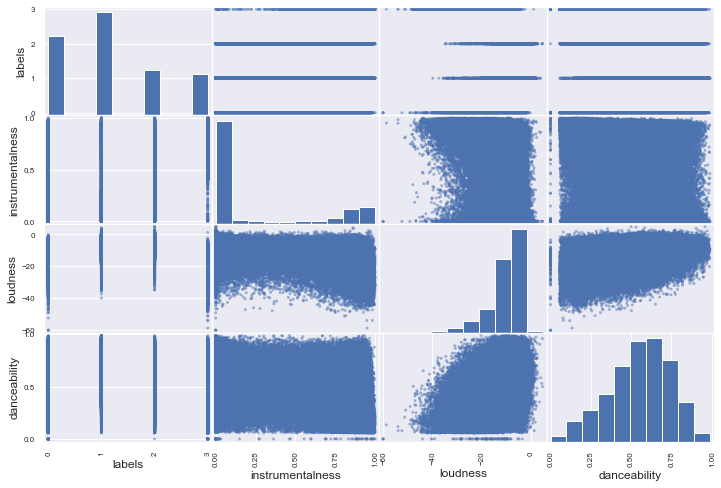

In [ ]:
# obtain the top most correlated factors to lables
top_correlated = base_df.corr()['labels'].abs()
top_correlated_2 = top_correlated.nlargest(4).index
scatter_matrix(base_df[top_correlated_2], figsize=(12, 8))
plt.show()

Text(0.5, 1.0, 'Energy QQ Plot')

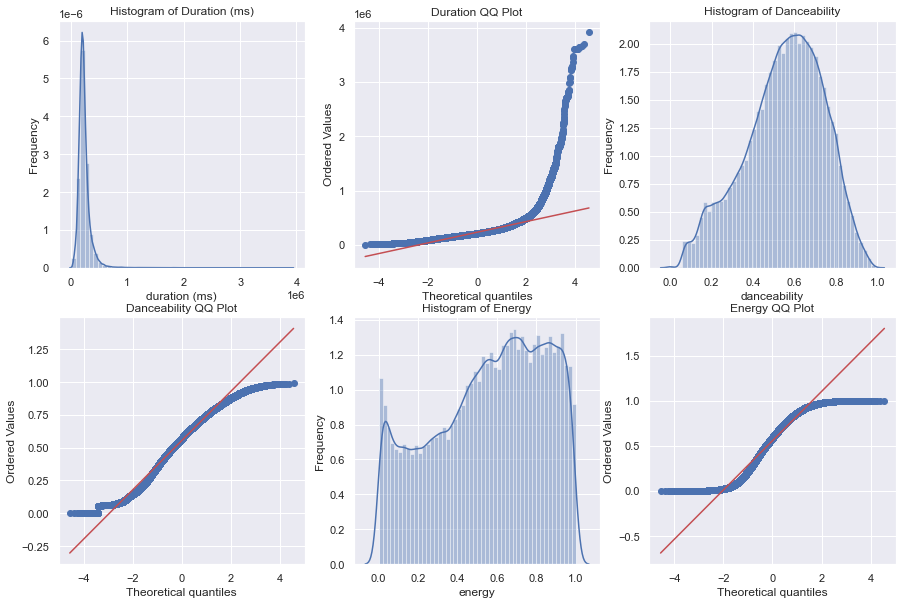

In [ ]:
# build histograms to get distribtuions
import scipy.stats as stats
fig= plt.figure(figsize = (15,10))
plt.subplot(2,3,1)
sns.distplot(base_df['duration (ms)'])
plt.ylabel("Frequency")
plt.title("Histogram of Duration (ms)")
plt.subplot(2,3,2)
stats.probplot(base_df['duration (ms)'], dist="norm", plot=plt)
plt.title('Duration QQ Plot')

plt.subplot(2,3,3)
sns.distplot(base_df['danceability'])
plt.ylabel("Frequency")
plt.title("Histogram of Danceability")
plt.subplot(2,3,4)
stats.probplot(base_df['danceability'], dist="norm", plot=plt)
plt.title('Danceability QQ Plot')


plt.subplot(2,3,5)
sns.distplot(base_df['energy'])
plt.ylabel("Frequency")
plt.title("Histogram of Energy")
plt.subplot(2,3,6)
stats.probplot(base_df['energy'], dist="norm", plot=plt)
plt.title('Energy QQ Plot')

Text(0.5, 1.0, 'Acousticness QQ Plot')

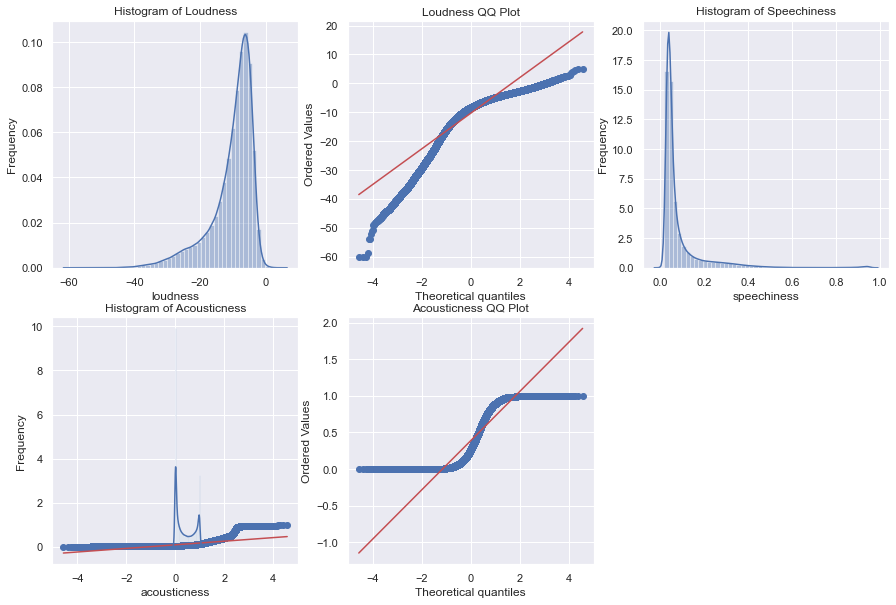

In [ ]:
fig= plt.figure(figsize = (15,10))
plt.subplot(2,3,1)
sns.distplot(base_df['loudness'])
plt.ylabel("Frequency")
plt.title("Histogram of Loudness")
plt.subplot(2,3,2)
stats.probplot(base_df['loudness'], dist="norm", plot=plt)
plt.title('Loudness QQ Plot')


plt.subplot(2,3,3)
sns.distplot(base_df['speechiness'])
plt.ylabel("Frequency")
plt.title("Histogram of Speechiness")
plt.subplot(2,3,4)
stats.probplot(base_df['speechiness'], dist="norm", plot=plt)
plt.title('Speechiness QQ Plot')

plt.subplot(2,3,4)
sns.distplot(base_df['acousticness'])
plt.ylabel("Frequency")
plt.title("Histogram of Acousticness")
plt.subplot(2,3,5)
stats.probplot(base_df['acousticness'], dist="norm", plot=plt)
plt.title('Acousticness QQ Plot')

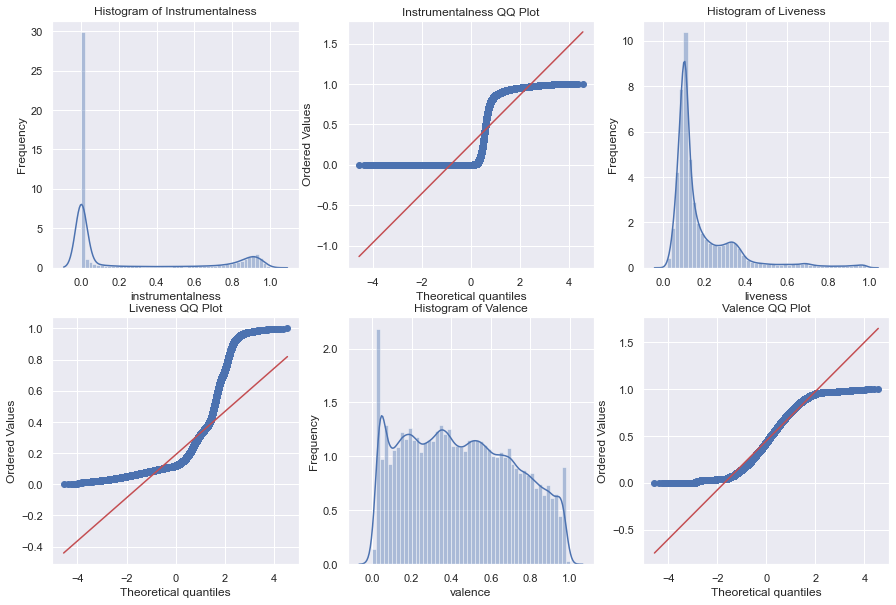

In [ ]:
fig= plt.figure(figsize = (15,10))
plt.subplot(2,3,1)
sns.distplot(base_df['instrumentalness'])
plt.ylabel("Frequency")
plt.title("Histogram of Instrumentalness")
plt.subplot(2,3,2)
stats.probplot(base_df['instrumentalness'], dist="norm", plot=plt)
plt.title('Instrumentalness QQ Plot')

plt.subplot(2,3,3)
sns.distplot(base_df['liveness'])
plt.ylabel("Frequency")
plt.title("Histogram of Liveness")
plt.subplot(2,3,4)
stats.probplot(base_df['liveness'], dist="norm", plot=plt)
plt.title('Liveness QQ Plot')


plt.subplot(2,3,5)
sns.distplot(base_df['valence'])
plt.ylabel("Frequency")
plt.title("Histogram of Valence")
plt.subplot(2,3,6)
stats.probplot(base_df['valence'], dist="norm", plot=plt)
plt.title('Valence QQ Plot')

plt.show();

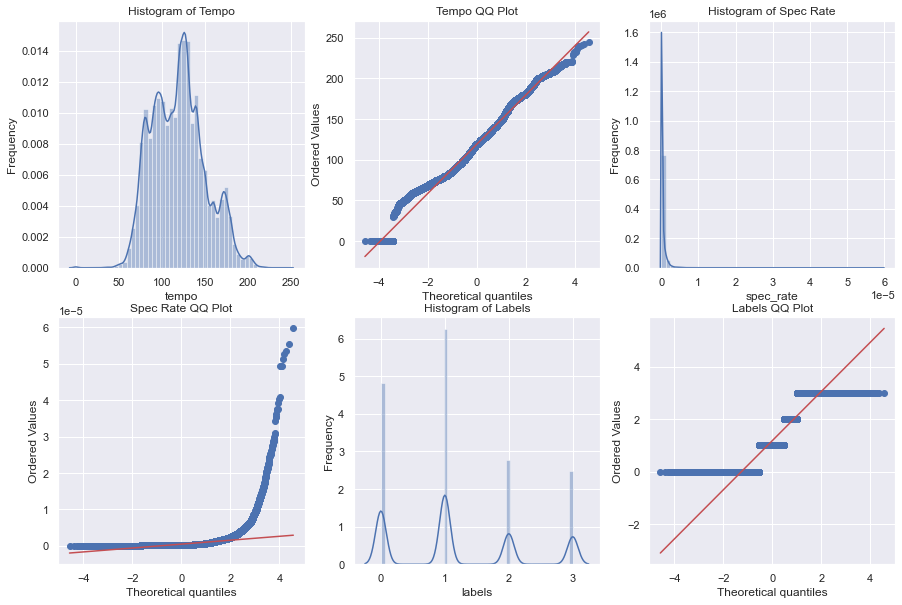

In [ ]:
fig= plt.figure(figsize = (15,10))
plt.subplot(2,3,1)
sns.distplot(base_df['tempo'])
plt.ylabel("Frequency")
plt.title("Histogram of Tempo")
plt.subplot(2,3,2)
stats.probplot(base_df['tempo'], dist="norm", plot=plt)
plt.title('Tempo QQ Plot')

plt.subplot(2,3,3)
sns.distplot(base_df['spec_rate'])
plt.ylabel("Frequency")
plt.title("Histogram of Spec Rate")
plt.subplot(2,3,4)
stats.probplot(base_df['spec_rate'], dist="norm", plot=plt)
plt.title('Spec Rate QQ Plot')

plt.subplot(2,3,5)
sns.distplot(base_df['labels'])
plt.ylabel("Frequency")
plt.title("Histogram of Labels")
plt.subplot(2,3,6)
stats.probplot(base_df['labels'], dist="norm", plot=plt)
plt.title('Labels QQ Plot')

plt.show();

A probability plot, also known as a quantile-quantile (QQ) plot, is a graphical tool used to assess whether a given dataset follows a particular theoretical distribution, such as a normal (Gaussian) distribution. The QQ plot compares the quantiles of the observed data to the quantiles of the theoretical distribution. If the data follows the theoretical distribution, the points on the QQ plot should roughly form a straight line.

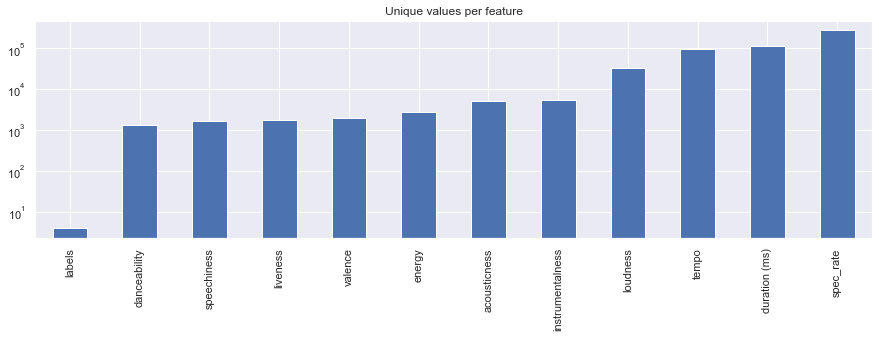

In [ ]:
# For each numerical feature compute number of unique entries
unique_values = base_df.select_dtypes(include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

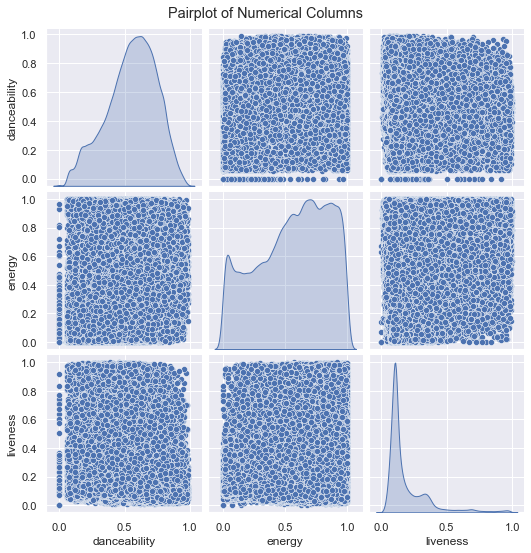

In [ ]:
# Choose multiple numerical columns for the pairplot
numerical_columns = ['danceability', 'energy', 'liveness']

# Create a pairplot
sns.pairplot(base_df[numerical_columns], diag_kind='kde')
plt.suptitle('Pairplot of Numerical Columns', y=1.02)
plt.show()

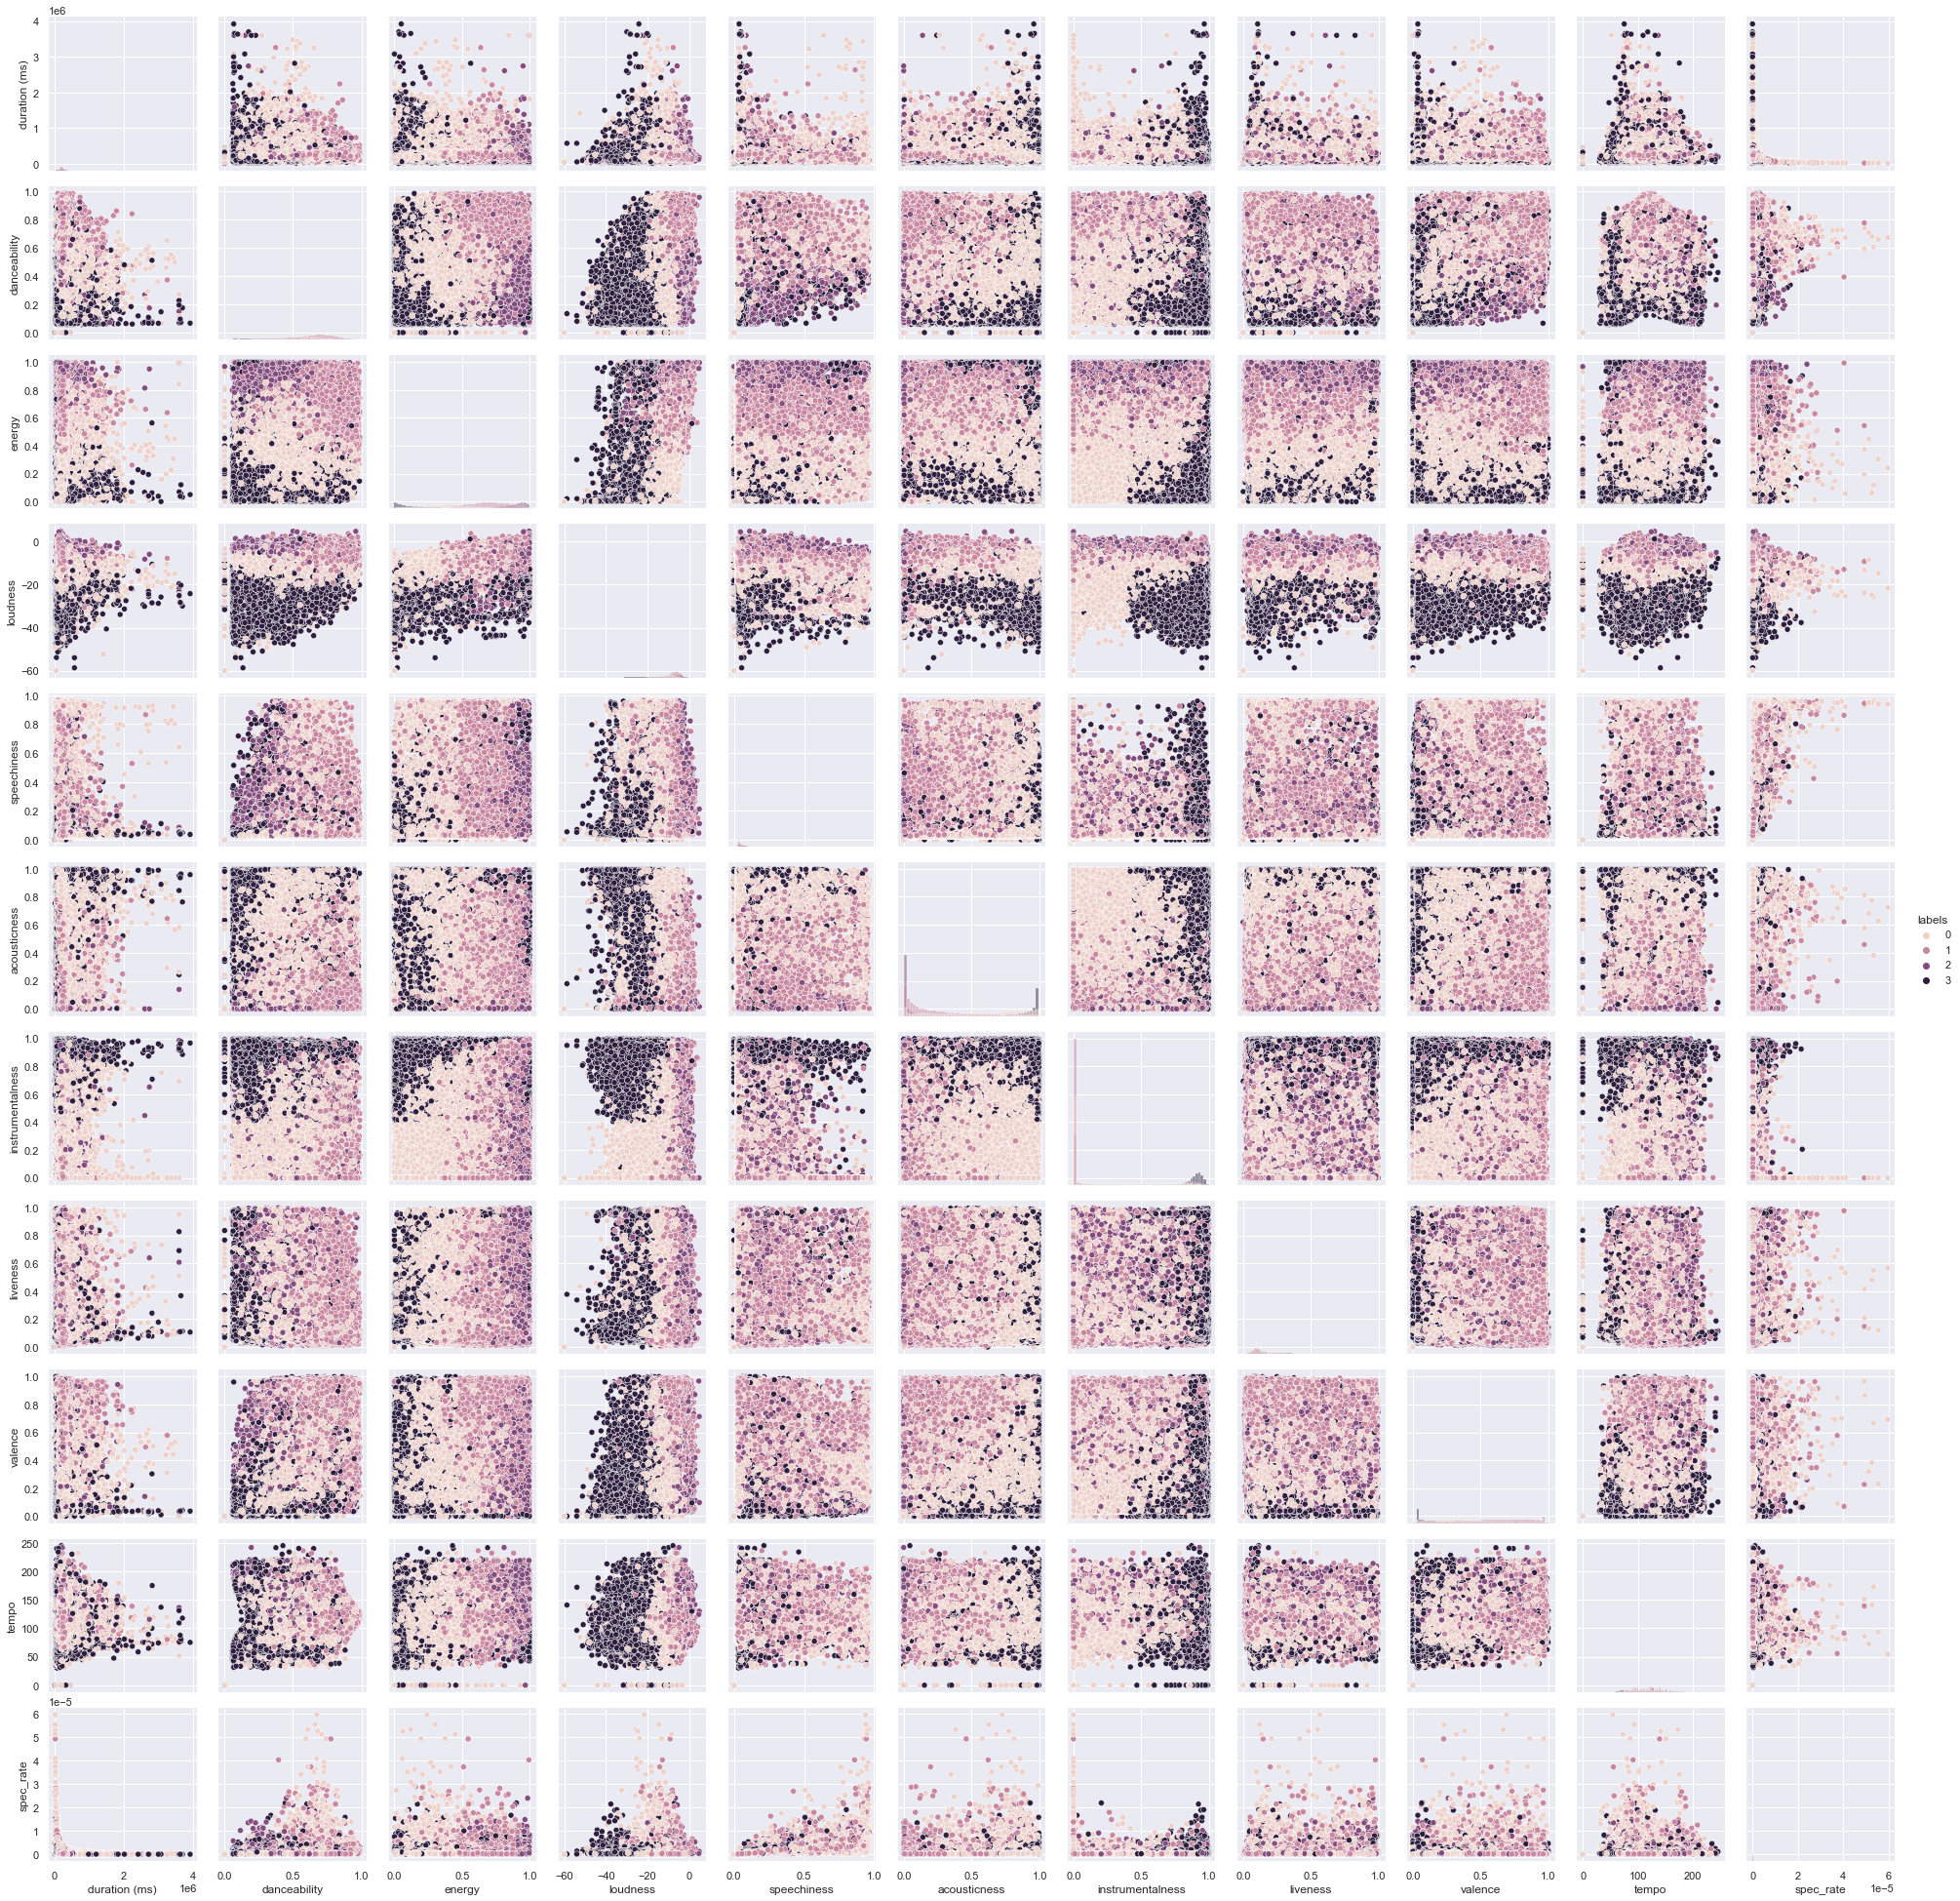

In [ ]:
g = sns.PairGrid(base_df, hue="labels")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

## 3. Building Models

## 4. Validation & Performance Metrics

## 5. Modeling Results & Findings